In [70]:
import tensorflow as tf
import keras
import PIL.Image as pil
import pathlib

# Loading data (fruits 360)

Datasets: 
- Fruits 360: https://www.kaggle.com/datasets/moltean/fruits
- Fruit Classification: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition 

In [71]:
# Counting images and setting up path

training_dir = pathlib.Path('./fruits-360/fruits-360_dataset/fruits-360/Training/')
test_dir = pathlib.Path('./fruits-360/fruits-360_dataset/fruits-360/Validation/')
train_count = len(list(training_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))
print("Number of training images:", train_count)
print("Number of training images:", test_count)

Number of training images: 35133
Number of training images: 11804


In [72]:
batch_size = 32
img_height = 100
img_width = 100

# Loading training data

train_ds = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Loading test data

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 35133 files belonging to 70 classes.
Found 11804 files belonging to 70 classes.


In [73]:
# Get class names

class_names = train_ds.class_names
num_classes = len(class_names)
class_names[:5]

['Apple Braeburn',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith']

## Previewing Images

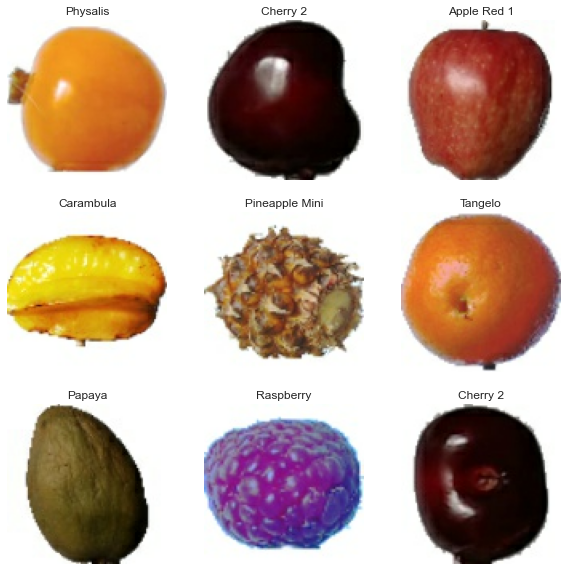

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Preprocessing

In [75]:
# Converting color values from 0-255 to 0-1

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [76]:
# Configuring dataset for performance
"""
Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
This will ensure the dataset does not become a bottleneck while training your model. 
If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch overlaps data preprocessing and model execution while training.
"""

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Tranining baseline model

In [77]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1/255),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(100, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [78]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [79]:
model.fit(
  train_ds,
#   validation_data=val_ds,
  epochs=3
)

Epoch 1/3
1098/1098 [==============================] - 1394s 1s/step - loss: 0.5616 - accuracy: 0.8404
Epoch 2/3
1098/1098 [==============================] - 974s 887ms/step - loss: 0.0717 - accuracy: 0.9758
Epoch 3/3
1098/1098 [==============================] - 1079s 983ms/step - loss: 0.0479 - accuracy: 0.9826


In [80]:
model.evaluate(test_ds)

369/369 [==============================] - 70s 180ms/step - loss: 0.2410 - accuracy: 0.9408


[0.24104677140712738, 0.9407827854156494]

In [81]:
model.save('tensorflow_base.h5')

# Creating Confusion Matrix

Goal of confusion matrix is to identify classes which the model struggels to identify, or often mistakes with another class. Just because the model accuracy is %95, this does not mean that every class is predicted with %95 accuracy. It could be that %95 of the classes are predicted with %100 accuracy and therefore we must verify that the accuracy of the model is evenly distributed throughout the classes.

In [82]:
import numpy as np

temp = [(x, y) for x, y in test_ds] # get x,y features from dataset
y = np.concatenate([y for x, y in temp], axis=0)
x = np.concatenate([x for x, y in temp], axis=0)

y_hat = model.predict(x)
y_hat = np.asarray(tf.math.argmax(y_hat, axis=1))

369/369 [==============================] - 73s 197ms/step


Text(156.453125, 0.5, 'Predicted')

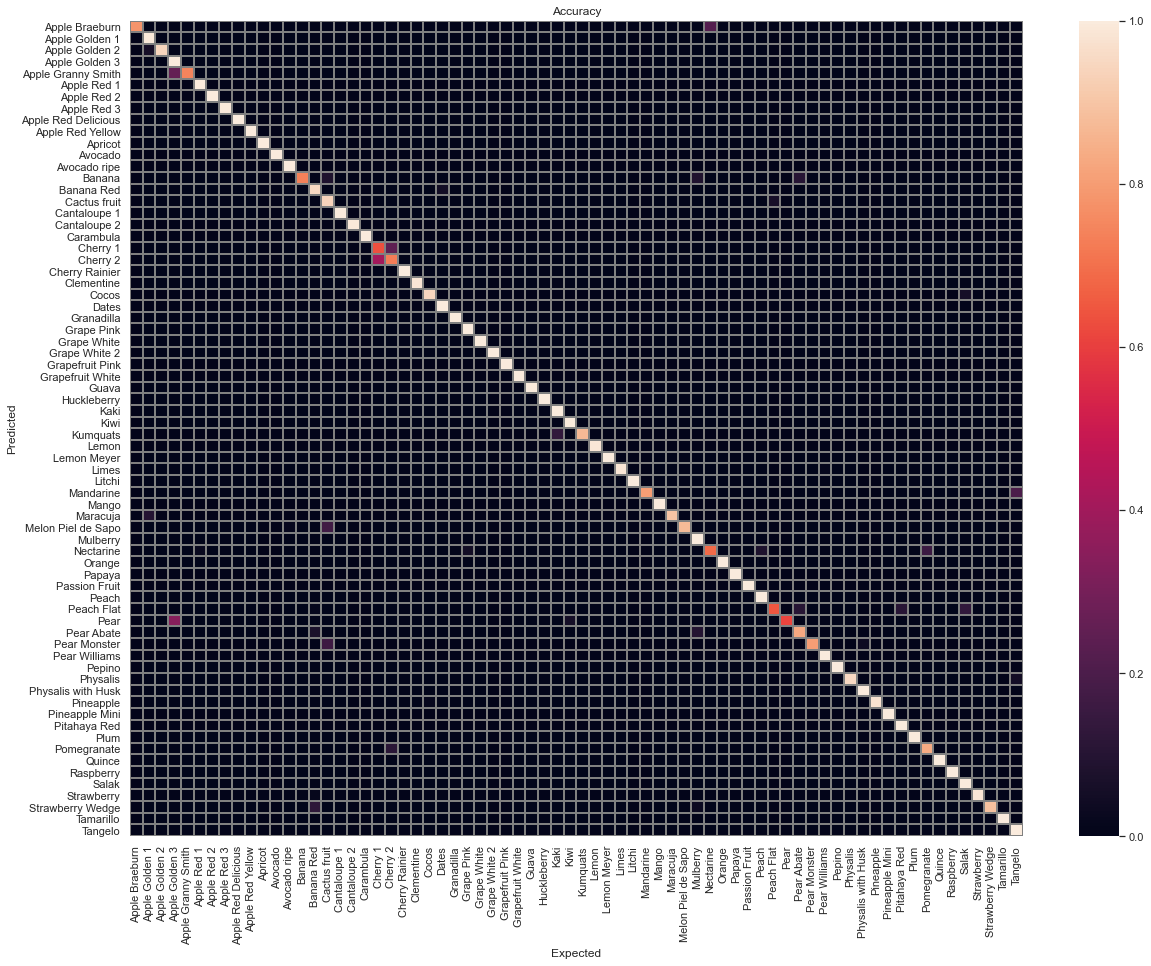

In [83]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,15)})

confusion_matrix = tf.math.confusion_matrix(y, y_hat)
confusion_matrix = confusion_matrix / tf.reduce_sum(confusion_matrix, axis=1)
sns.heatmap(confusion_matrix, xticklabels=class_names, yticklabels=class_names, linecolor='grey', linewidth=2)
plt.title('Accuracy')
plt.xlabel('Expected')
plt.ylabel('Predicted')